In [1]:
import os
import pandas as pd
import copy
from pdf2image import convert_from_path
from PIL import Image

import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

In [2]:
CSV_FILE       = "dataset.csv"        # CSV with 'primary_genre' and 'pdf' columns
PDF_FOLDER     = "archives"       # folder containing PDF files
IMG_SIZE       = (512, 512)
BATCH_SIZE     = 12
VAL_SPLIT      = 0.2
NUM_EPOCHS     = 10
LEARNING_RATE  = 1e-3
RANDOM_SEED    = 42
torch.manual_seed(RANDOM_SEED)

EARLY_STOP_PATIENCE = 3  # number of epochs with no improvement to stop

## Data loading pipeline

In [3]:
df = pd.read_csv(CSV_FILE)

In [4]:
# Get unique genres
unique_genres = df["primary_genre"].unique()
# We create mapping for string labels to ints
genre_to_idx  = {genre: idx for idx, genre in enumerate(unique_genres)}
idx_to_genre  = {idx: genre for genre, idx in genre_to_idx.items()}

num_classes = len(genre_to_idx)
print("Discovered classes:", genre_to_idx)

Discovered classes: {'Classical': 0, 'Electronic & Dance': 1, 'Folk/World': 2, 'Jazz & Blues': 3, 'Pop': 4, 'R&B, Soul & Hip-Hop': 5, 'Religious': 6, 'Rock & Metal': 7, 'Soundtrack': 8}


### Dataset class creation

In [5]:
class SheetMusicPDFDataset(Dataset):
    """
    Reads a CSV with columns: 'primary_genre', 'pdf'.
    For each row, it converts the specified PDF (first page) into a PIL image.
    """
    def __init__(self, csv_path, pdf_folder, transform=None, label_map=None):
        self.df = pd.read_csv(csv_path)
        self.pdf_folder = pdf_folder
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Extract label
        genre_str  = row["primary_genre"]
        label      = self.label_map[genre_str]  # integer label

        # Extract the PDF filename
        pdf_filename = row["pdf"]
        pdf_path     = os.path.join(self.pdf_folder, pdf_filename)

        # Convert the PDF to a list of PIL Images (we only take the first page)
        try:
            pages = convert_from_path(pdf_path, dpi=300, first_page=1, last_page=1)
        except Exception as e:
            # If there's an error reading the PDF, handle it
            raise RuntimeError(f"Error reading PDF {pdf_path}: {e}")

        # We'll assume at least one page was found
        pil_image = pages[0]

        # Apply later transforms (e.g., grayscale, resize, ToTensor, etc.)
        if self.transform:
            pil_image = self.transform(pil_image)

        return pil_image, label

### Transformations for images

In [6]:
# We'll define separate transforms for train vs val if we want data augmentation in training.
train_transform = T.Compose([
    T.Grayscale(num_output_channels=1),  # convert to 1-channel grayscale
    T.Resize(IMG_SIZE),
    T.RandomRotation(degrees=5),         # small rotation only (careful with notes and musical information)
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize(IMG_SIZE),
    T.ToTensor(),
])

### Dataset creation

In [7]:
full_dataset = SheetMusicPDFDataset(
    csv_path=CSV_FILE,
    pdf_folder=PDF_FOLDER,
    transform=None,  # We'll set transforms after splitting
    label_map=genre_to_idx
)

### Split and loading

In [8]:
# Randomly split into train/val
dataset_length = len(full_dataset)
val_size       = int(VAL_SPLIT * dataset_length)
train_size     = dataset_length - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Assign transforms to each subset
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = val_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Total samples: {dataset_length}, Train: {train_size}, Val: {val_size}")

Total samples: 33468, Train: 26775, Val: 6693


### Visualization to check loading (sanity check)

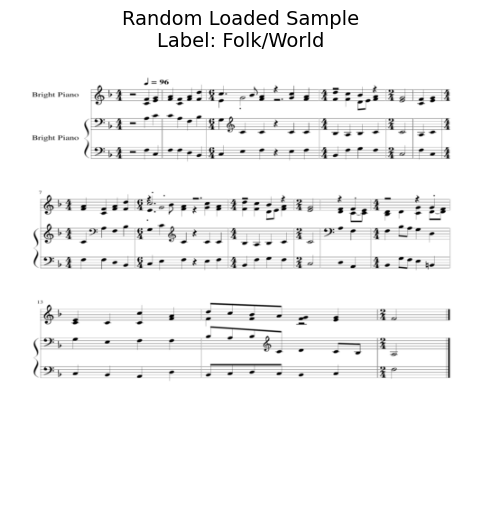

In [9]:
# Pick a random index for a random sample
random_idx = random.randint(0, len(full_dataset) - 1)

# Retrieve the sample
sample_img, sample_label = full_dataset[random_idx]

# We apply val_transform for display if not applied, just to ensure consistent sizing
if isinstance(sample_img, Image.Image):
    sample_img = val_transform(sample_img)

# Map label back to string
genre_name = idx_to_genre[sample_label] if sample_label in idx_to_genre else sample_label

# Plot
plt.figure(figsize=(6,6))             
plt.imshow(sample_img.squeeze(0), cmap='gray')
plt.title(f"Random Loaded Sample\nLabel: {genre_name}", fontsize=14)
plt.axis('off')                      
plt.show()

## Model Definition (change)

In [10]:
class SimpleCNN(nn.Module): 
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input shape: (1, 512, 512) if using Grayscale
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (16, 256, 256)
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (32, 128, 128)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (64, 64, 64)
        )
        
        # After 3 pool layers, each dimension is divided by 2^3 = 8
        # So for a 512×512 input, we now have 64×64×64 features
        # Flatten shape is 64 * 64 * 64 = 262144
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE[0]//8) * (IMG_SIZE[1]//8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

model = SimpleCNN(num_classes=num_classes)


## Training

### Training setup

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Use ReduceLROnPlateau to reduce LR if val_loss stops improving.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Early stopping variables
best_val_loss = float("inf")
best_model_wts = copy.deepcopy(model.state_dict())
no_improve_count = 0

# Lists to track metrics for plotting
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

Using: cuda


### Training loop

In [ ]:
for epoch in range(NUM_EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_epoch_loss = running_loss / total
    train_epoch_acc  = running_correct / total
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)

    # --- VALIDATION ---
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc  = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}   | Val Acc: {val_epoch_acc:.4f}")

    # We'll step the scheduler based on validation loss
    scheduler.step(val_epoch_loss)

    # --- EARLY STOPPING CHECK ---
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_count = 0
    else:
        no_improve_count += 1
        print(f"No improvement for {no_improve_count} epoch(s)")

        if no_improve_count >= EARLY_STOP_PATIENCE:
            print("Early stopping triggered!")
            break

print("Training complete!")

# Load best weights
model.load_state_dict(best_model_wts)

### Plot curves

In [ ]:
plt.figure(figsize=(12,5))

# --- LOSS ---
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses,   label='Val Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# --- ACCURACY ---
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs,   label='Val Acc', marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout